In [241]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pybloom import BloomFilter
import inspect
import matplotlib.font_manager
from sklearn import svm

In [242]:
def generateGauss(numcompo, gap, sigma, numelepercompo):
    mu = 0
    ans = []
    for i in range(0, numcompo):
        s = np.random.normal(mu, sigma, numelepercompo)
#         print(s)
        ans += s.tolist()
        mu += gap
    return np.array([ans]).transpose()


In [243]:
def generateGaussArr(numcompo, gap, sigma, numelepercompo):
    mu = 0
    ans = []
    for i in range(0, numcompo):
        s = np.random.normal(mu, sigma, numelepercompo)
#         print(s)
        ans.append(s)
        mu += gap
    return np.array(ans)


In [267]:
from sklearn import preprocessing
import numpy as np
import sys
from sklearn.metrics import accuracy_score
import pickle
from sklearn import mixture
import math

def ngram(X, gramsize):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    reqdim = maxlen - gramsize +1
    
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        if len(tempy) == 0:
            tempy = [paddedi]
        templeny = len(tempy)
        
        Y.append(tempy)
    return Y

def ngramEnforce(X, gramsize, reqdim):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    maxlen = reqdim + gramsize -1
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        templeny = len(tempy)
        
        Y.append(tempy)
    return np.array(Y)

def rstripfn(x):
    x = x.rstrip('\n')
    
    return x.rstrip('\n')

def getDataInString(filename):
    with open(filename) as f1:
        lst1 = map(rstripfn,f1.readlines())
    return lst1

def findngram(gramsize, lst1):
    lst1g = ngram(lst1, gramsize)

    reqdim = len(lst1g[0])
    lst1f = []
    for i in lst1g:
        lst1f.append(map(float, i))

    nplst1 = np.array(lst1f)
    return (nplst1,reqdim)

def preprocess_train(nplst1):
    lstf1 = nplst1.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    lstS1 = min_max_scaler.fit_transform(lstf1)
    return lstS1, min_max_scaler

def preprocess_test(nplst1, min_max_scaler):
    lstf1 = nplst1.astype(float)
    lstS1 = min_max_scaler.transform(lstf1)
    return lstS1

def trainfn(lstS1, n_compo, maxiter):
    clf = mixture.GaussianMixture(n_components=n_compo, covariance_type='full', max_iter=maxiter)
    clf.fit(lstS1)
    return clf

def findmeansigma(clf, lstS1):
    meanscore = np.mean(clf.score_samples(lstS1))
    meanvar = np.var(clf.score_samples(lstS1))
    sigma = math.sqrt(meanvar)
    return (meanscore, sigma)

def mypred(X, clf, mean, sigma):
    scores = clf.score_samples(X)
    print(scores)
    predictions = []
    for i in scores:
        print("diff is ",abs(i-mean))
        if(abs(i-mean)<=max(thres*sigma, 1.0/1e12)):
            predictions.append(1)
        else:
            predictions.append(-1)
    return predictions
def mypredSvm(X, clf):
    scores = clf.predict(X)
    return clf.predict(X)

def calcncompo(n):
    if(n>10000):
        return 100
    elif(n<60):
        return max(1, n/10)
    else:
        return 9

def areAllNumeric(l):
    l1 = map(isCharacterAscii, l)
    return all(l1)

def isCharacterAscii(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

def train(filename, sstableID):
    lst1 = getDataInString(filename)
    if(not areAllNumeric(lst1)):
        print("returning cause key is not numeric")
        return
    if(len(lst1) == 1):
        print('returning cause num key is 1')
        return
    nplst1, reqdim = findngram(gramsize, lst1)
    lstS1, min_max_scaler = preprocess_train(nplst1)
    n_compo = calcncompo(len(lst1))
    clf = trainfn(lstS1, n_compo, maxiter)
    mean, sigma = findmeansigma(clf, lstS1)
    models[str(sstableID)] = (clf, mean, sigma, reqdim, min_max_scaler)
    print('training done with sstableid - ', sstableID)
    return

def trainIndi(nplst1, sstableID,n_compo):
#     lst1 = getDataInString(filename)
#     if(not areAllNumeric(lst1)):
#         print("returning cause key is not numeric")
#         return
#     if(len(lst1) == 1):
#         print('returning cause num key is 1')
#         return
#     nplst1, reqdim = findngram(gramsize, lst1)
#     print("prev mean was ", np.mean(nplst1.transpose()))
#     print("prev var was ", np.var(nplst1.transpose()))
#     lstS1, min_max_scaler = preprocess_train(nplst1)
    print("passed mean was ",np.mean(nplst1.transpose()))
    print("passed sigma was ",np.var(nplst1.transpose()))
#     n_compo = calcncompo(len(lst1))
    clf = trainfn(nplst1, n_compo, maxiter)
    print("found means ")
    print(np.sort(clf.means_.transpose()[0]))
    print("cov matrix ")
    print(clf.covariances_)
    print("weights :")
    print(clf.weights_)
    mean, sigma = findmeansigma(clf, nplst1)
    print("mean is ",str(mean))
    print("sigma is ", str(sigma))
    reqdim = len(nplst1[0])
    models[str(sstableID)] = (clf, mean, sigma, reqdim)
    print('training done with sstableid - ', sstableID)
    return

def trainIndiSvm(nplst1, sstableID):
    print("passed mean was ",np.mean(nplst1.transpose()))
    print("passed sigma was ",np.var(nplst1.transpose()))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return
def test(keyPredstr, sstableID):
    if(keyPredstr == ''):
        print('returning cause string is empty')
        return 0
    if(not isCharacterAscii(keyPredstr)):
        print('returning cause not numric')
        return 0
    keyPred = [str(keyPredstr)]
    if sstableID in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
        keyPredS = preprocess_test(keyPredg, min_max_scaler)
        prediction = mypred(keyPredS, clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

    
def testIndi(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred([keyPredg], clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm([keyPredg], clf)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

def testIndi2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred(keyPredg, clf, mean, sigma)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm(keyPredg, clf)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def sizeofmodels():
    l = []
    for sstableID in models:
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
def sumsizeofmodels(models):
    agg =0
    for sstableID in models:
        clf, mean, sigma, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvm(models):
    agg =0
    for sstableID in models:
        clf, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofbloom(bloomfilters):
    agg =0
    for f in bloomfilters.values():
        agg += f.num_bits
    agg = agg/8
    return agg




In [268]:
gramsize = -1
maxiter = 100
models = {} # storing models based on sstable ids

In [269]:
numclustersPerSStable = 10
numclustersPerSStableForTrain = numclustersPerSStable
numSstable = 2
numelePerCluster = 20
gapBetweenClusters = 0.5
clusterSigma = 0.1
ssTableData = {}
nu = 0.1
gamma = 20


In [270]:
thres = -0.1
bloomfilters = {}
capacityBloom = 30000
errorRate = 0.1
skipFactor = 1

In [271]:
# Generate the data
alltemptableData = generateGaussArr(
    numclustersPerSStable*numSstable, gapBetweenClusters, clusterSigma, numelePerCluster )
np.random.shuffle(alltemptableData)
for i in range(0,numSstable):
    thistableData = alltemptableData[i*numclustersPerSStable:(i+1)*numclustersPerSStable].flatten()
    ssTableData[i] = thistableData.reshape(-1,1)

In [272]:
ssTableData

{0: array([[ 5.48494013],
        [ 5.52826844],
        [ 5.36461379],
        [ 5.67365516],
        [ 5.53288891],
        [ 5.48924671],
        [ 5.56707422],
        [ 5.47208534],
        [ 5.4680575 ],
        [ 5.59637124],
        [ 5.59238247],
        [ 5.44109202],
        [ 5.71578886],
        [ 5.45712374],
        [ 5.51436656],
        [ 5.48159294],
        [ 5.55215972],
        [ 5.56318863],
        [ 5.44896312],
        [ 5.54195648],
        [ 7.5879815 ],
        [ 7.50460315],
        [ 7.61298444],
        [ 7.34858384],
        [ 7.70316414],
        [ 7.44300334],
        [ 7.4116488 ],
        [ 7.46816904],
        [ 7.40598648],
        [ 7.51249266],
        [ 7.38611302],
        [ 7.63840242],
        [ 7.39406047],
        [ 7.62596844],
        [ 7.44036876],
        [ 7.41814325],
        [ 7.72427434],
        [ 7.55310029],
        [ 7.70060517],
        [ 7.55522385],
        [-0.05252664],
        [ 0.07731227],
        [ 0.02290022],
        

In [273]:
# alltemptableData

In [274]:
%%time
# train the model on generated data
for i in range(0,numSstable):
    thistableData = ssTableData[i]
    trainIndiSvm(thistableData,i)


('passed mean was ', 5.553237806094938)
('passed sigma was ', 8.872356589438638)
('training done with sstableid - ', 0)
('passed mean was ', 3.9596898941326186)
('passed sigma was ', 6.53234750098263)
('training done with sstableid - ', 1)
CPU times: user 3.76 ms, sys: 775 µs, total: 4.53 ms
Wall time: 3.12 ms


In [275]:
# %%time
# put into bloom filter false negatives
for i in range(0,numSstable):
    thistableData = ssTableData[i]
    thistableDataTranspose0 = thistableData.transpose()[0]
    falseNegativeAns = testIndiSvm2(thistableData, i)
#     print(falseNegativeAns)
    numFalseNeg = falseNegativeAns.tolist().count(-1)
#     newCapacity = int(capacityBloom*1.0*numFalseNeg/len(thistableData))
    newCapacity = max(numFalseNeg,1)
    print("newCapacity ",newCapacity)
    f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
    for j in range(0,len(thistableDataTranspose0)):
        if(falseNegativeAns[j]==-1):
#             print("adding ", thistableDataTranspose0[j])
            f.add(thistableDataTranspose0[j])
    bloomfilters[i] = f

('newCapacity ', 26)
('newCapacity ', 34)


In [276]:
%%time
# create test data
# For now test data is all data
# calculate false positives for test data
truePositive_c=0
truePositive_bf=0
truePositive=0
falsePositive_c=0
falsePositive_bf=0
falsePositive=0
trueNegative=0
for i in range(0, numSstable):
    print("on sstable number ", i)
    thistableData = ssTableData[i]
    thistableDataTranspose0 = thistableData.transpose()[0]
    for elemind in range(0,len(thistableDataTranspose0),skipFactor):
        elem = thistableDataTranspose0[elemind]
        for j in range(0,numSstable):
            cAnswer = (testIndiSvm([elem],j)==1)
#             print(cAnswer)
            if not cAnswer:
                bfAnswer = elem in bloomfilters[j]
                finAnswer = bfAnswer
            else:
                bfAnswer = None
                finAnswer = cAnswer
            if finAnswer:
                if(i==j):
                    #True answer true positive
                    #break because you found answer
                    truePositive+=1
                    if bfAnswer is None:
                        truePositive_c+=1
                    else:
                        truePositive_bf+=1
                    break
                else:
                    #False answer false positive
                    falsePositive+=1
                    if bfAnswer is None:
                        falsePositive_c+=1
                    else:
                        falsePositive_bf+=1
            else:
                if(i==j):
                    raise ValueEroor("not possible")
                else:
                    #True answer true negative
                    trueNegative+=1
                
        


('on sstable number ', 0)


ValueError: Expected 2D array, got 1D array instead:
array=[5.48494013].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [254]:
print(truePositive,falsePositive,trueNegative)

(400, 1, 199)


In [255]:
print(truePositive_c,truePositive_bf,falsePositive_c,falsePositive_bf)

(325, 75, 0, 1)


In [256]:
fprate = falsePositive*1.0/(falsePositive+trueNegative)
print(fprate)

0.005


In [223]:
sumsizeofmodelssvm(models)

yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=20, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('1', 5465)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=20, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('0', 4726)


10191

In [224]:
sumsizeofbloom(bloomfilters)

95

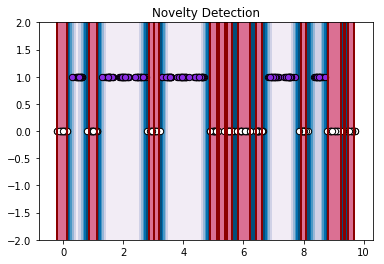

In [225]:
ssTableNumber = 0
clf = models[str(0)][0]
xx, yy = np.meshgrid(
    np.linspace(min(alltemptableData.flatten()), max(alltemptableData.flatten()), 500), np.linspace(-2, 2, 500))
Z = clf.decision_function(np.c_[xx.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
s = 40
b1 = plt.scatter(ssTableData[ssTableNumber][:, 0], ssTableData[ssTableNumber][:, 0]*0, c='white', s=s, edgecolors='k')
testData = [ssTableData[i] for i in ssTableData if i!=ssTableNumber]
b2 = plt.scatter(testData[0][:, 0], testData[0][:, 0]*0+1, c='blueviolet', s=s,
                 edgecolors='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 0]*0+2, c='gold', s=s,
#                 edgecolors='k')

In [126]:
sys.getsizeof(models['0'])

72

In [127]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    else:
        print(type(obj))
        print("cases left")
    return size

In [128]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                print(type(obj))
                print(sys.getsizeof(obj))
                size += sys.getsizeof(obj)
                print(size)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [129]:
getsize(models['0'][0].weights_)

AttributeError: 'OneClassSVM' object has no attribute 'weights_'

In [ ]:
models['0'][0].covariances_.shape

In [ ]:
type(models['0'][0].weights_[0])

In [ ]:
tempint = 0
get_size(tempint)

In [ ]:
inspect.getmembers(models['0'][0].means_, lambda a:not(inspect.isroutine(a)))

In [ ]:
attributes = inspect.getmembers(models['0'][0], lambda a:not(inspect.isroutine(a)))

In [ ]:
[a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]

In [97]:
max(alltemptableData.flatten())

149.6821688911806

In [108]:
alltemptableData.reshape(-1,1)

array([[49.01943014],
       [48.85071482],
       [48.98366142],
       ...,
       [18.95085099],
       [18.94604311],
       [19.28825076]])

In [150]:
loldata = [ssTableData[i] for i in ssTableData if i!=ssTableNumber]

In [151]:
loldata[0]

array([[0.52353581],
       [0.46816131],
       [0.36282367],
       [0.64871072],
       [0.32902386],
       [0.49270312],
       [0.58351997],
       [0.65194046],
       [0.51552926],
       [0.54146075],
       [0.57311023],
       [0.52782243],
       [0.40241516],
       [0.50059871],
       [0.54584825],
       [0.5333304 ],
       [0.53657363],
       [0.41542434],
       [0.34998389],
       [0.5487896 ],
       [1.46876288],
       [1.32104549],
       [1.63565645],
       [1.52886051],
       [1.38952213],
       [1.63353662],
       [1.58255851],
       [1.67175134],
       [1.45556962],
       [1.53432124],
       [1.59951233],
       [1.41932166],
       [1.46943063],
       [1.49656045],
       [1.33728587],
       [1.2940343 ],
       [1.56756497],
       [1.51819883],
       [1.49556489],
       [1.55743974]])